KAGGLE TITANIC MODEL SELECTION

In [1]:
#paketi
#general
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#modeli
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from lightgbm import LGBMClassifier
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu, pearsonr

In [36]:
#imamo dataframe train_kon, test_kon gdje su popunjeni svi missinzi i napravljeni featuresi
#importanje
train_pom=pd.read_csv("C:\\Users\\ante1\\OneDrive\\Radna površina\\kaggle titanic\\train_novi.csv")
test=pd.read_csv("C:\\Users\\ante1\\OneDrive\\Radna površina\\kaggle titanic\\test_novi.csv")

In [7]:
train_pom.columns

Index(['Unnamed: 0', 'PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age',
       'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'FS',
       'Is_alone', 'FS_kat', 'Fare_rescaled', 'Fare_log_kat',
       'Cabin_is_missing', 'Brojevi', 'Ime_karte_missing', 'Ime_kabine_kat',
       'Age_kat'],
      dtype='object')

In [16]:
train_pom.dtypes

Unnamed: 0             int64
PassengerId            int64
Survived               int64
Pclass                 int64
Name                  object
Sex                   object
Age                  float64
SibSp                  int64
Parch                  int64
Ticket                object
Fare                 float64
Cabin                 object
Embarked              object
FS                     int64
Is_alone              object
FS_kat               float64
Fare_rescaled        float64
Fare_log_kat           int64
Cabin_is_missing       int64
Brojevi               object
Ime_karte_missing      int64
Ime_kabine_kat         int64
Age_kat               object
dtype: object

In [37]:
#feature importance preko chisq i pearsona
# Perform tests for each variable against 'Survived'
tests_results = []

for column in train_pom.columns:
    if column == 'Survived':
        continue  # Skip 'Survived' variable itself

    # Categorical variables: Chi-square test
    if train_pom[column].dtype == 'object':
        contingency_table = pd.crosstab(train_pom[column], train_pom['Survived'])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        test_result = {'varijabla': column,'test': 'Chi-square', 'chi2': chi2, 'p-value': p}
    
    # Numerical variables: T-test (assuming normally distributed)
    elif train_pom[column].dtype in ['int64', 'float64']:
        corr_coef, p_value = pearsonr(train_pom[column], train_pom['Survived'])
        test_result = {'varijabla': column, 'test': 'Pearons signif','koef': corr_coef, 'p-value': p_value}
    
    # You can add more tests for other variable types if needed
    
    tests_results.append(test_result)

# Create a DataFrame from results
results_df = pd.DataFrame(tests_results)

# Sort DataFrame by P-value in ascending order
results_df_sorted = results_df.sort_values(by='p-value')

In [38]:
results_df_sorted

,varijabla,test,koef,p-value,chi2
4,Sex,Chi-square,NaN,1.197357e-58,260.717020
2,Pclass,Pearons signif,-0.338481,2.537047e-25,NaN
15,Fare_rescaled,Pearons signif,0.329862,4.646670e-24,NaN
17,Cabin_is_missing,Pearons signif,-0.316912,3.090891e-22,NaN
14,FS_kat,Chi-square,NaN,6.522920e-17,74.537249
16,Fare_log_kat,Pearons signif,0.265841,7.043655e-16,NaN
9,Fare,Pearons signif,0.257307,6.120189e-15,NaN
13,Is_alone,Chi-square,NaN,1.972654e-09,36.000514
11,Embarked,Chi-square,NaN,2.300863e-06,25.964453
20,Ime_kabine_kat,Pearons signif,-0.144659,1.459109e-05,NaN


In [43]:
#encoding kateogrijalnih varijabli 
#train
train_pom=pd.get_dummies(train_pom, columns=['Sex'])
#train_pom=pd.get_dummies(train_pom, columns=['Is_alone'])
#train_pom=pd.get_dummies(train_pom, columns=['FS_kat'])
#train_pom=pd.get_dummies(train_pom, columns=['Embarked'])
#test
test=pd.get_dummies(test, columns=['Sex'])
#test=pd.get_dummies(test, columns=['Is_alone'])
#test=pd.get_dummies(test, columns=['FS_kat'])
#test=pd.get_dummies(test, columns=['Embarked'])

In [10]:
#RESCALING
#train
train_pom['Age']=MinMaxScaler().fit_transform(train_pom['Age'].array.reshape(-1, 1))
train_pom['Fare']=MinMaxScaler().fit_transform(train_pom['Fare'].array.reshape(-1, 1))
#test
test['Age']=MinMaxScaler().fit_transform(test['Age'].array.reshape(-1, 1))
test['Fare']=MinMaxScaler().fit_transform(test['Fare'].array.reshape(-1, 1))

In [11]:
#izbacujemo ticket, cabin, name, FS, PassengerId, unamaed 0, imena, brojevi, Brojevi

mozda u pomocni string pisati imena cega izbacujemo da bude lakse

In [44]:
#podjela u train test
y=train_pom['Survived']
X=train_pom.drop(['Survived','Unnamed: 0','Ime_karte_missing','FS','SibSp','Age','Parch','Fare','Embarked','Is_alone','FS_kat'],axis=1)
X.columns = X.columns.astype(str)
#tt split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y,test_size=0.1, random_state=0)
#kreiranje zasebnog test seta
X_test=test.drop(['Unnamed: 0','Ime_karte_missing','FS','SibSp','Age','Parch','Fare','Embarked','Is_alone','FS_kat'],axis=1)

In [45]:
#classifiers
classifiers = {
    "LogisticRegression" : LogisticRegression(random_state=0),
    "RandomForest" : RandomForestClassifier(random_state=0),
    "LGBM" : LGBMClassifier(random_state=0)
}
LR_grid = {'penalty': ['l1','l2'],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'max_iter': [50, 100, 150]}
RF_grid = {'n_estimators': [20, 30, 40, 50],
        'max_depth': [1, 2, 3, 4]}
boosted_grid = {'n_estimators': [50, 100],
        'max_depth': [4,6,8],
        'learning_rate': [0.05, 0.1, 0.15]}
grid = {
    "LogisticRegression" : LR_grid,
    "RandomForest" : RF_grid,
    "LGBM" : boosted_grid
}

In [46]:
#validation
i=0
clf_best_params=classifiers.copy()
valid_scores=pd.DataFrame({'Classifer':classifiers.keys(), 'Validation accuracy': np.zeros(len(classifiers)), 'Training time': np.zeros(len(classifiers))})
for key, classifier in classifiers.items():
    start = time.time()
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)

    # Train and score
    clf.fit(X_train, y_train)
    valid_scores.iloc[i,1]=clf.score(X_valid, y_valid)

    # Save trained model
    clf_best_params[key]=clf.best_params_
    
    # Print iteration and training time
    stop = time.time()
    valid_scores.iloc[i,2]=np.round((stop - start)/60, 2)
    
    print('Model:', key)
    print('Training time (mins):', valid_scores.iloc[i,2])
    print('')
    i+=1

C:\Users\ante1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
90 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ante1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ante1\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ante1\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1168, in fit
    solver = 

Model: LogisticRegression
Training time (mins): 0.03

Model: RandomForest
Training time (mins): 0.1

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 307, number of negative: 494
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135
[LightGBM] [Info] Number of data points in the train set: 801, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383271 -> initscore=-0.475688
[LightGBM] [Info] Start training from score -0.475688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

In [47]:
valid_scores

,Classifer,Validation accuracy,Training time
0,LogisticRegression,0.766667,0.03
1,RandomForest,0.777778,0.10
2,LGBM,0.788889,0.08


In [48]:
# Show best parameters from grid search
clf_best_params

{'LogisticRegression': {'C': 0.25, 'max_iter': 50, 'penalty': 'l2'},
 'RandomForest': {'max_depth': 4, 'n_estimators': 20},
 'LGBM': {'learning_rate': 0.15, 'max_depth': 6, 'n_estimators': 50}}

In [49]:
#radimo crossvalidation na najboljim klasifikatorima
# Classifiers
best_classifiers = {
    "RandomForest" : RandomForestClassifier(**clf_best_params["RandomForest"], random_state=0),
}

In [18]:
X_test['Fare_rescaled'][152]

2.737880811060884

In [50]:
# Number of folds in cross validation
FOLDS=10

preds=np.zeros(len(X_test))
for key, classifier in best_classifiers.items():
    start = time.time()
    
    # 10-fold cross validation
    cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=0)
    
    score=0
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        # Get training and validation sets
        X_train, X_valid = X.loc[train_idx], X.loc[val_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[val_idx]

        # Train model
        clf = classifier
        clf.fit(X_train, y_train)

        # Make predictions and measure accuracy
        preds += clf.predict_proba(X_test)[:,1] #objasnjenje
        score += clf.score(X_valid, y_valid)

    # Average accuracy    
    score=score/FOLDS
    
    # Stop timer
    stop = time.time()

    # Print accuracy and time
    print('Model:', key)
    print('Average validation accuracy:', np.round(100*score,2))
    print('Training time (mins):', np.round((stop - start)/60,2))
    print('')
    
# Ensemble predictions
preds=preds/(FOLDS*len(best_classifiers))

Model: RandomForest
Average validation accuracy: 80.36
Training time (mins): 0.02



Text(0.5, 0, 'Probability')

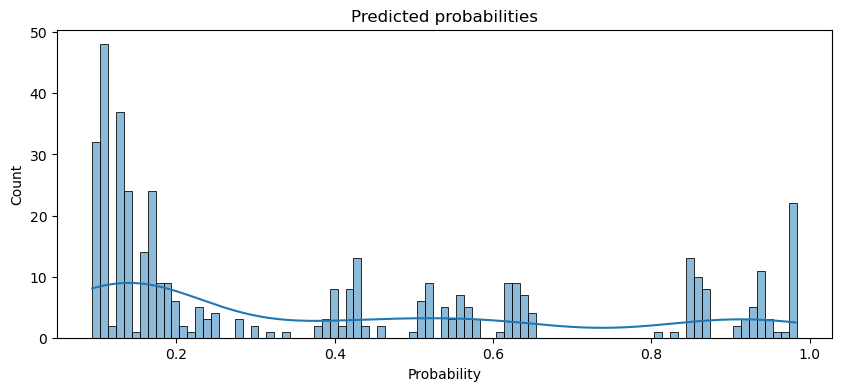

In [51]:
#radimo prediction na test setu
plt.figure(figsize=(10,4))
sns.histplot(preds, binwidth=0.01, kde=True)
plt.title('Predicted probabilities')
plt.xlabel('Probability')

In [52]:
# Proportion (in test set) we get from rounding
print(np.round(100*np.round(preds).sum()/len(preds),2))

35.65


Optimal threshold: 0.554


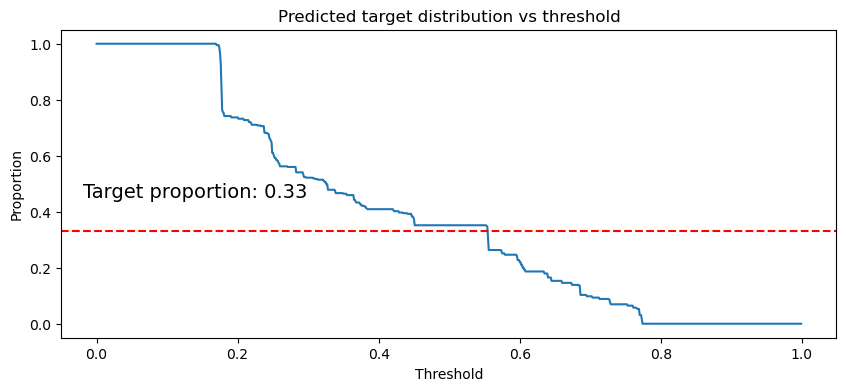

In [25]:
# Proportion of predicted positive (transported) classes
def preds_prop(preds_arr, thresh):
    pred_classes=(preds_arr>=thresh).astype(int)
    return pred_classes.sum()/len(pred_classes)
# proporcija 1 u uzorku 

# Plot proportions across a range of thresholds
def plot_preds_prop(preds_arr):
    # Array of thresholds
    T_array=np.arange(0,1,0.001)
    
    # Calculate proportions
    prop=np.zeros(len(T_array))
    for i, T in enumerate(T_array):
        prop[i]=preds_prop(preds_arr, T)
        
    # Plot proportions
    plt.figure(figsize=(10,4))
    plt.plot(T_array, prop)
    target_prop=0.33      # Experiment with this value
    plt.axhline(y=target_prop, color='r', linestyle='--')
    plt.text(-0.02,0.45,f'Target proportion: {target_prop}', fontsize=14)
    plt.title('Predicted target distribution vs threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Proportion')
    
    # Find optimal threshold (the one that leads to the proportion being closest to target_prop)
    T_opt=T_array[np.abs(prop-target_prop).argmin()]
    print('Optimal threshold:', T_opt)
    return T_opt
    
T_opt=plot_preds_prop(preds)
#kako eksperinentirati ?

In [53]:
# Classify test set using optimal threshold
preds_tuned=(preds>=0.50).astype(int)

In [54]:
# Sample submission (to get right format)
sub=pd.read_csv("C:\\Users\\ante1\\OneDrive\\Radna površina\\kaggle titanic\\gender_submission.csv")
# Add predictions
sub['Survived']=preds_tuned
sub

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


Text(0.5, 1.0, 'Prediction distribution')

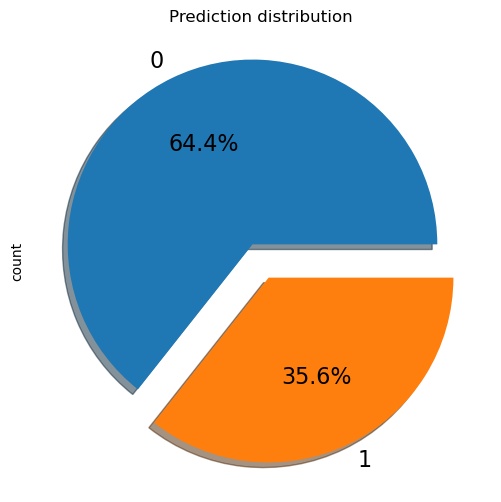

In [55]:
# Prediction distribution
plt.figure(figsize=(6,6))
sub['Survived'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).set_title("Prediction distribution")

In [56]:
sub

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [57]:
# Output to csv
sub.to_csv("C:\\Users\\ante1\\OneDrive\\Radna površina\\kaggle titanic\\submission_1.csv", index=False)